# Spectrophotometric flux calibration with template spectra

In spectroscopy, the flat-field does *not* yield the sensivity as function of wavelength, since the flat-field lamp has its own intrinsic spectrum.  To flux-calibrate observed spectra, we have to compare the observed spectrum of a reference star to its known true spectrum.  The ratio of the two then yields the sensitivity function as function of wavelength.  (Think of the sensivity function measuring "counts per unit flux".)

In this course, quite often we can approximate this process by comparing the flux of an A star (which have few lines) to the spectrum of a blackbody with the same temperature as the star.  However, since stars are not perfect blackbodies, the following presents a method to use a stellar template spectrum instead.  Here, we will use the template spectra from the Pickles library.

## Prepare background-subtracted, 1-d, wavelength-calibrated spectrum of reference star:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,4)

from astropy.io import fits

In [2]:
# read in a 2-d, background-subtracted star spectrum:
hdulist = fits.open('star_bkgsub.fits')
star_all = hdulist[0].data
ncols = np.shape(star_all)[1]
x=np.arange(ncols)

# collapse to 1d spectrum by summing over rows that contain flux from star 
# (approximately rows 22-50):
star = np.sum(star_all[22:50,:], axis=0)

In [3]:
# build a 1-d array for the x-coordinates, that is the same length as the spectrum:
x=np.arange(ncols)

# wavelength solution determined from 2nd-order fit to arc lines:
wavelength_sol2=[2.85936499e-05, 9.03255653e-01, 4.31448027e+03]

# make a wavelength array:
wavelength = x**2*wavelength_sol2[0] + x*wavelength_sol2[1] + wavelength_sol2[2]

Text(0, 0.5, 'Flux [Counts]')

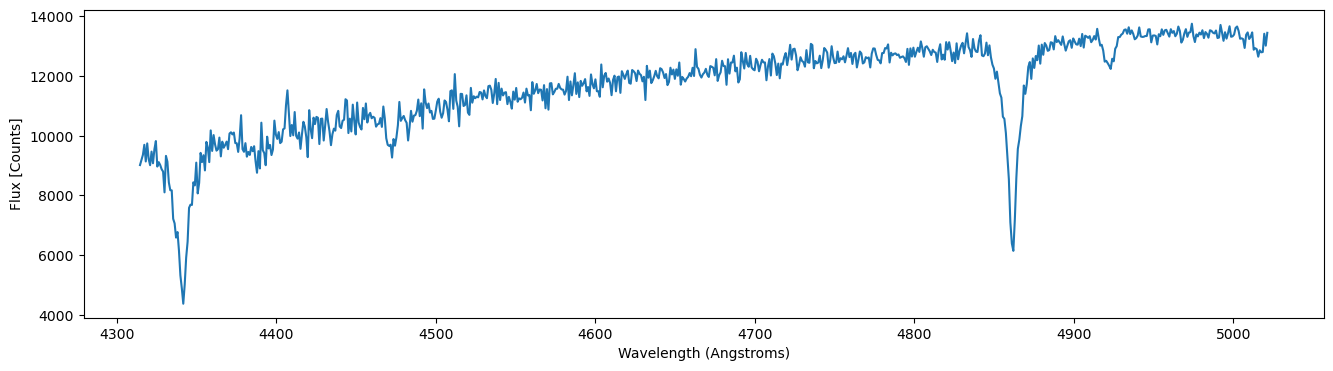

In [4]:
plt.plot(wavelength,star)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux [Counts]")

## Load the Pickles Atlas

The Pickles Atlas can be found at this link:

https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/pickles-atlas

The library contains 131 flux calibrated stellar spectra over a broad range of spectral types and luminosity classes. There are two libraries: UVI which covers 1150-10620 Å and UVK which covers 1150-25000 Å. We will use the UVI library. 

You can download the UVI spectra by going to the "Access the PICKLES ATLAS" link and utilizing the ```wget``` command with recursive flag. You may have to add the ```-e robots=off``` flag to tell the website you aren't a robot, which will allow download permissions.

You should have a folder with 131 spectra named ```pickles_*.fits``` and a reference table named ```pickles.fits```.

In [5]:
#hdulist_info = fits.open('tutorial/dat_uvi/pickles.fits')
hdulist_info = fits.open('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/pickles/dat_uvi/pickles.fits')
header_info = hdulist_info[0].header
data_info = hdulist_info[1].data

You can look on the website or in `data_info` for which fits file corresponds to the spectral type of your reference star. You need to use the closest spectral type/temperature (OBAFGKM) *and* you need to make sure it's the same luminosity class (I, II, III, IV, V) because they will have different absorption lines present.

In this example, the B5III template `pickles_63` at 14791.1 K is the closest to our reference.

In [6]:
hdulist_pickles = fits.open('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/pickles/dat_uvi/pickles_63.fits')
header_pickles = hdulist_pickles[0].header
data_pickles = hdulist_pickles[1].data
data_pickles

FITS_rec([( 1150., 5.7648595e-08), ( 1155., 5.8533907e-08),
          ( 1160., 4.5490207e-08), ..., (10610., 4.2425818e-10),
          (10615., 4.3642781e-10), (10620., 3.3564257e-10)],
         dtype=(numpy.record, [('WAVELENGTH', '>f4'), ('FLUX', '>f4')]))

The data in this fits file is a np.record, and is straightforward to access.

**For fun:** What does `>f4` dtype mean?

In [7]:
wavelength_pickles = data_pickles['WAVELENGTH']
flux_pickles = data_pickles['FLUX']

# We truncate the very wide template spectrum to our reference spectrum
wavelength_pickles_truncated = wavelength_pickles[(wavelength_pickles >= min(wavelength)) & (wavelength_pickles <= max(wavelength))]
flux_pickles_truncated = flux_pickles[(wavelength_pickles >= min(wavelength)) & (wavelength_pickles <= max(wavelength))]

Note the template spectrum has been multiplied by a constant because it's in `erg cm-2 s-1 Angstrom-1`, so we can see the two spectra on the same graph.


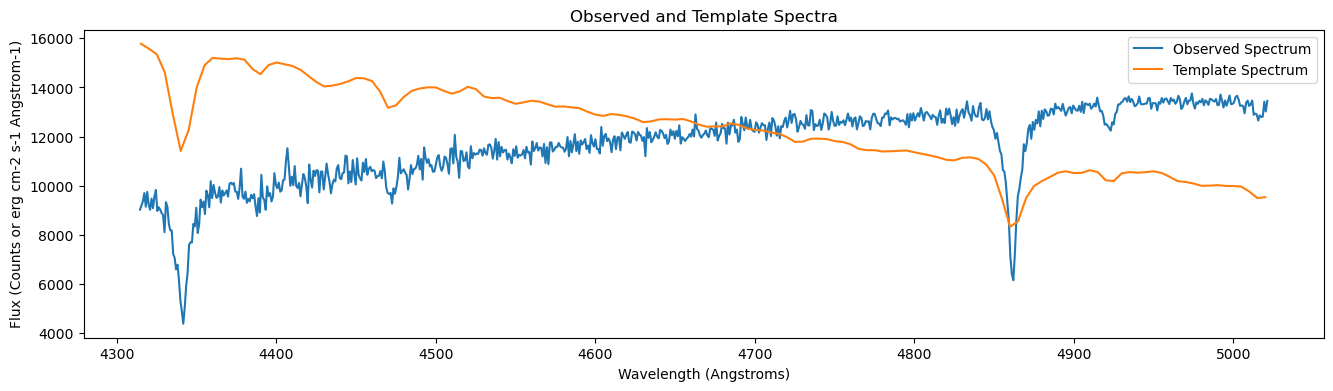

In [8]:
plt.plot(wavelength,star,label='Observed Spectrum')
plt.plot(wavelength_pickles_truncated, flux_pickles_truncated*2*10**12,label='Template Spectrum')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (Counts or erg cm-2 s-1 Angstrom-1)")
plt.title('Observed and Template Spectra')
plt.legend()
plt.show()

Let's compare the template to a perfect blackbody. It's easy to see why a template might be preferable, especially for the wavelengh range bluer than around 4000$\mathring{A}$.

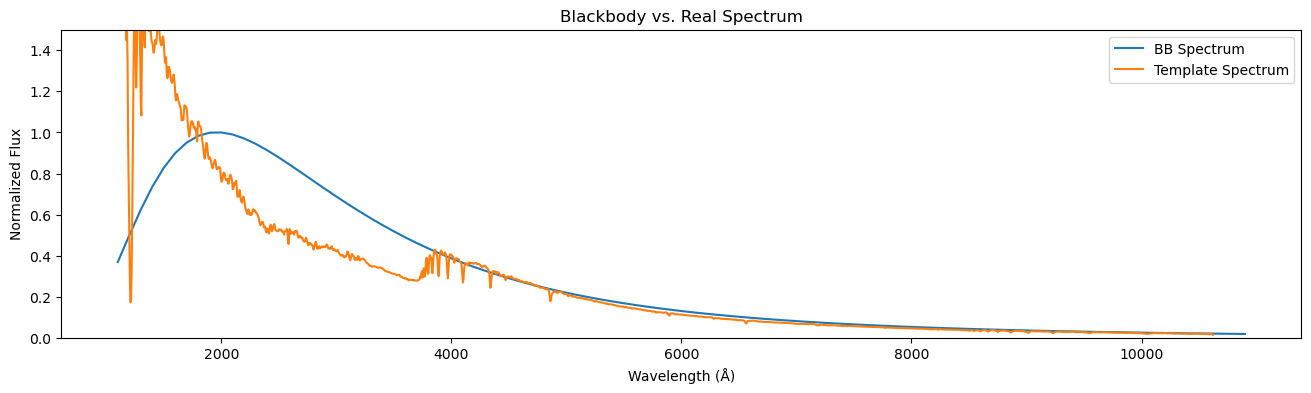

In [9]:
from astropy import units as u
from astropy.constants import sigma_sb, c, h, k_B

# Star temperature
T = 14791.1 * u.K

bb_wavelengths = np.arange(1100, 11000, 100) * u.AA

# B_nu = (2 * h * nu^3 / c^2) / (exp(h * nu / (k_B * T)) - 1)
# Units of erg cm^-2 s^-1 Hz^-1
bb_spec_AA = (2 * h * c**2 / bb_wavelengths**5) / (np.exp(h * c / (bb_wavelengths * k_B * T)) - 1)
bb_spec_AA = bb_spec_AA.to(u.erg / (u.cm**2 * u.s * u.AA))

normalized_bb_spec_AA = bb_spec_AA / np.max(bb_spec_AA)
#normalized_pickles_spec = flux_pickles / np.max(flux_pickles)
# include a fudge factor to make them line up:
normalized_pickles_spec = flux_pickles / np.max(flux_pickles)*2.5

# Plot the blackbody curve
plt.plot(bb_wavelengths.value, normalized_bb_spec_AA, label='BB Spectrum')
plt.plot(wavelength_pickles, normalized_pickles_spec,label='Template Spectrum')
plt.ylim(0,1.5)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Normalized Flux')
plt.title('Blackbody vs. Real Spectrum')
plt.legend()
plt.show()

## Resampling the observed and template spectra to a common grid

A tricky problem to solve when working with spectra from different sources is that the wavelength axis does not match up perfectly with each other. For example, the first spectra may have flux measurements at 4501, 4502, 4053 angstroms while another spectra may have flux measurements at 4501.5, 4502.5, 4503.5 angstroms. Even if they cover the same range overall, they usually have different sampling rates (number of points), so we need to interpolate the spectra to the same number of wavelength values and same wavelength values overall.

In the following, we use the [specutils](https://specutils.readthedocs.io/en/stable/) package which has many useful spectroscopy tools. Note that they use astropy units to keep track of dimensions throughout the calculations.

For anaconda/miniconda, you can install it via `conda install -c conda-forge specutils`, otherwise you can install it with `pip install specutils` if you have another python distribution.

In [10]:
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import template_logwl_resample
from specutils.manipulation import LinearInterpolatedResampler
from specutils.manipulation import extract_region

In [11]:
wavelength_with_units = wavelength * u.AA # AA = angstrom
star_with_units = star * u.ct  # unit of counts
wavelength_pickles_with_units = wavelength_pickles * u.AA
flux_pickles_with_units = flux_pickles * u.Unit('erg cm-2 s-1 Angstrom-1')

In [12]:
# Read our spectrum into a Spectrum1D object for specutils
observed_spec = Spectrum1D(spectral_axis=wavelength_with_units, flux=star_with_units)
pickles_spec = Spectrum1D(spectral_axis=wavelength_pickles_with_units, flux=flux_pickles_with_units)
observed_spec

<Spectrum1D(flux=[9019.1884765625 ... 13449.123046875] ct (shape=(765,), mean=11651.78809 ct); spectral_axis=<SpectralAxis [4314.48027    4315.38355425 4316.28689568 ... 5019.36380884 5020.31066981
 5021.25758796] Angstrom> (length=765))>

Spectrum1D objects are usually convenient to work with. When you call `spec.spectral_axis` or `spec.flux` it will return an array with the astropy unit attached. If you don't want the astropy units and just want the pure array values (due to package incompatibilities for example) then call `spec.spectral_axis.value` or `spec.flux.value`.

Specutils comes with a `template_logwl_resample` function, which resamples an observed spectrum and a template spectrum onto a common log-spaced spectral grid. Here, we will use the `LinearInterpolatedResampler` class which simply linearly interpolates between the points. `"truncate"` indicates to cut off the trailing and leading 0's in our observed spectrum that we don't need (recall that our template covers a much wider range).

In [13]:
observed_spec_resampled, pickles_spec_resampled = template_logwl_resample(observed_spec, pickles_spec, resampler=LinearInterpolatedResampler("truncate"))

The following is just to make sure the two spectra cover our desired wavelength range.

In [14]:
wavelength_pickles_resampled_truncated = pickles_spec_resampled.spectral_axis[(pickles_spec_resampled.spectral_axis >= min(observed_spec_resampled.spectral_axis))
                                            & (pickles_spec_resampled.spectral_axis <= max(observed_spec_resampled.spectral_axis))]
flux_pickles_resampled_truncated = pickles_spec_resampled.flux[(pickles_spec_resampled.spectral_axis >= min(observed_spec_resampled.spectral_axis))
                                            & (pickles_spec_resampled.spectral_axis <= max(observed_spec_resampled.spectral_axis))]
pickles_spec_resampled_truncated = Spectrum1D(spectral_axis=wavelength_pickles_resampled_truncated, flux=flux_pickles_resampled_truncated)

Now, it is simple to overplot the observed spectrum and the template spectrum (note that there is a rescaling of the template flux for better legibility):

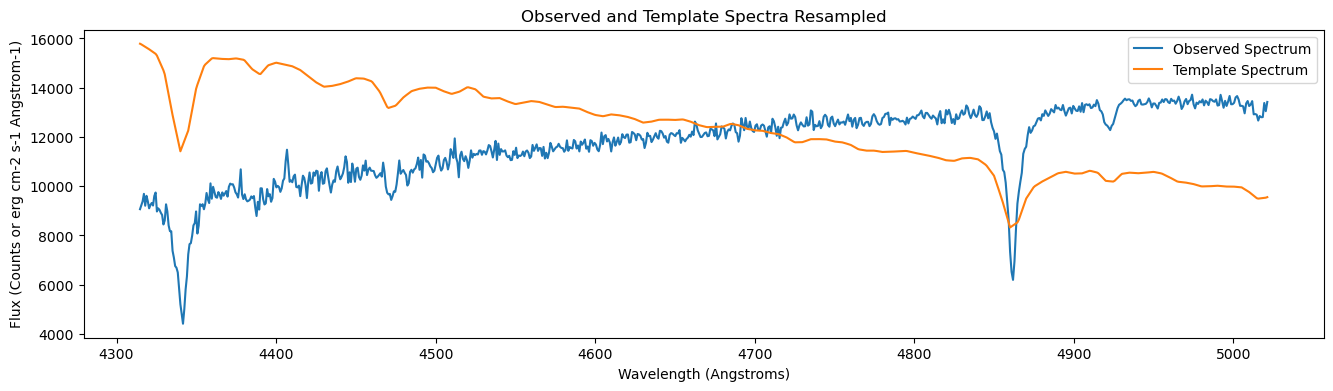

In [15]:
plt.plot(observed_spec_resampled.spectral_axis, observed_spec_resampled.flux, label='Observed Spectrum')
plt.plot(pickles_spec_resampled_truncated.spectral_axis, pickles_spec_resampled_truncated.flux*2*10**12, label='Template Spectrum')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (Counts or erg cm-2 s-1 Angstrom-1)")
plt.title('Observed and Template Spectra Resampled')
plt.legend()
plt.show()

Zooming in on one of the observed absorption lines, we can see that the resample has preserved the data while making sure the observed spectrum and the template spectrum share the same x values.

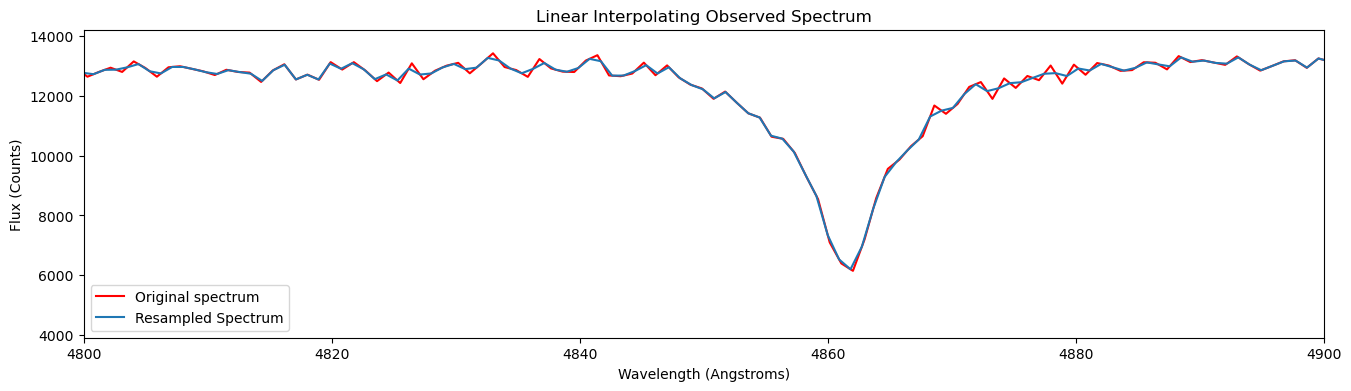

In [16]:
plt.plot(observed_spec.spectral_axis, observed_spec.flux, label="Original spectrum", color="red")
plt.plot(observed_spec_resampled.spectral_axis, observed_spec_resampled.flux, label="Resampled Spectrum")
plt.xlim(4800, 4900)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (Counts)")
plt.title('Linear Interpolating Observed Spectrum')
plt.legend()
plt.show()

## Deriving the sensitivity function

At this point, we can take the ratio of observed flux to template flux for every wavelength pixel. Since there is noise in both spectra, we will fit the ratio with a low-order polynomial to arrive at the sensivity function.

Depending on the data, this can be done in one of three ways:

### a) Absorption lines do not bias the fit
*IF* the observed spectrum has very few, narrow absorption lines, so that they do not bias a polynomial fit, then it is possible to derive the sensivity function without further steps.

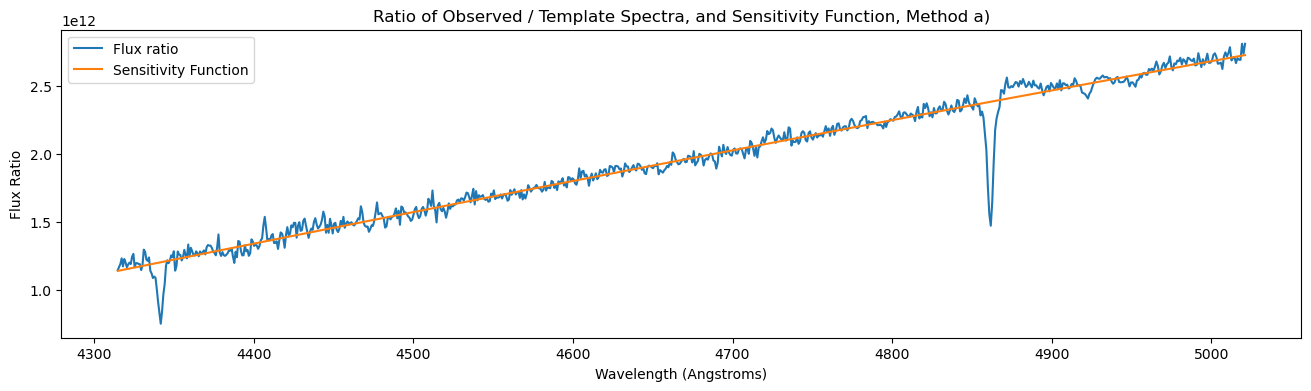

[-1.70669405e+05  3.83492045e+09 -1.22264807e+13]


In [17]:
ratio_a = observed_spec_resampled / pickles_spec_resampled_truncated

# Determine the sensitivity function:
coeffs_a = np.polyfit(ratio_a.spectral_axis.value, ratio_a.flux.value, 2)
sensitivity_function_a = np.polyval(coeffs_a, ratio_a.spectral_axis.value)

plt.plot(ratio_a.spectral_axis, ratio_a.flux, label='Flux ratio')
plt.plot(ratio_a.spectral_axis.value, sensitivity_function_a, label='Sensitivity Function')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux Ratio")
plt.title('Ratio of Observed / Template Spectra, and Sensitivity Function, Method a)')
plt.legend()
plt.show()

print(coeffs_a)

### b) Mask absorption lines

Same as when using a blackbody spectrum as template.

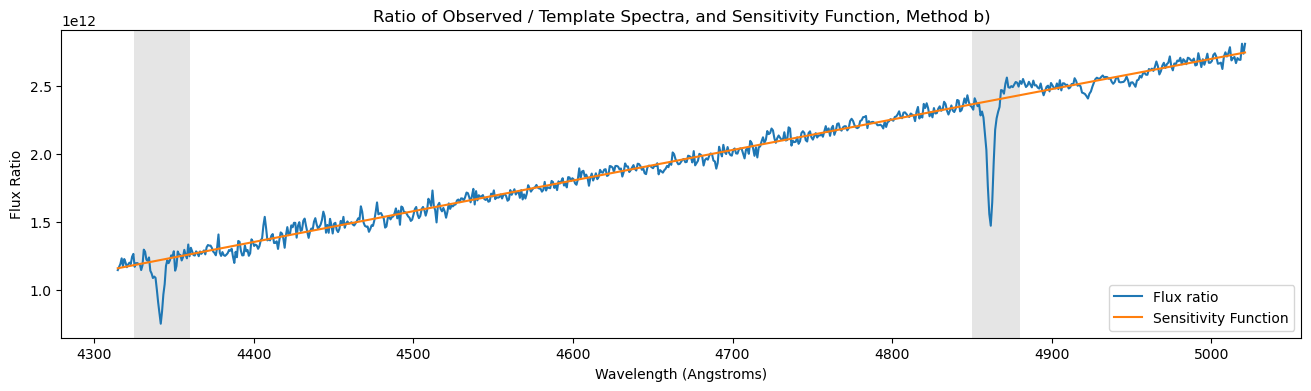

[-3.86584029e+04  2.60180944e+09 -9.34424961e+12]


In [18]:
# Same as before
ratio_a = observed_spec_resampled / pickles_spec_resampled_truncated

# Make a mask:
mask = np.ones(len(ratio_a.spectral_axis.value))
mask = np.where((ratio_a.spectral_axis.value>4325) & (ratio_a.spectral_axis.value<4360),0,mask)
mask = np.where((ratio_a.spectral_axis.value>4850) & (ratio_a.spectral_axis.value<4880),0,mask)

# Determine the sensitivity function.  This time, use the mask as weight for polyfit.
coeffs_b = np.polyfit(ratio_a.spectral_axis.value, ratio_a.flux.value, 2, w=mask)
sensitivity_function_b = np.polyval(coeffs_b, ratio_a.spectral_axis.value)

plt.plot(ratio_a.spectral_axis, ratio_a.flux, label='Flux ratio')
plt.plot(ratio_a.spectral_axis.value, sensitivity_function_b, label='Sensitivity Function')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux Ratio")
plt.title('Ratio of Observed / Template Spectra, and Sensitivity Function, Method b)')
plt.legend()
plt.axvspan(4325, 4360, color='gray', alpha=0.2, lw=0)
plt.axvspan(4850, 4880, color='gray', alpha=0.2, lw=0)
plt.show()

print(coeffs_b)

### c) Convolve to same resolution

By now you are probably wondering why the absorption lines show up in the ratio, given that they are in both the observed and the template spectrum.  This might be because the lines are intrinsically different (different strengths, and different widths), but even if we were observing the same star as the template, they would have different _observed_ widths, since the spectral resolution of the template is not the same as that of the observed spectrum.

Therefore, the ratio is not an accurate estimator of the sensitivity function around the absorption lines.  For stars with many absorption lines, this becomes a problem when deriving the sensivitiy function.

Fortunately, we can solve this by convolving the higher-resolution spectrum to the same resolution as the lower-resolution one..

First we will find the line width (i.e. the Gaussian standard deviation) for each spectrum. We can retrieve this by fitting a gaussian an absorption line in each spectrum. We can use `scipy curve_fit` for this.

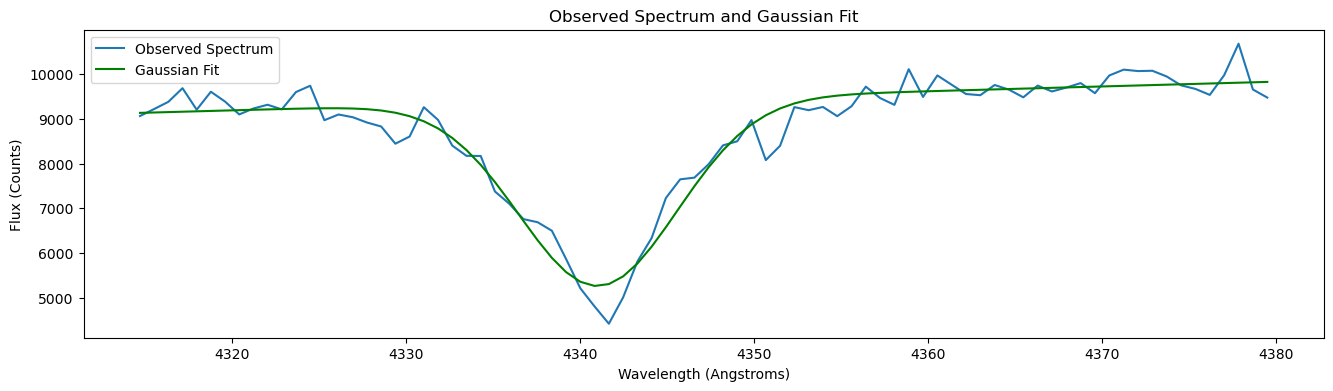

Fitted parameters: y0 = -37034.90, m = 10.70, Amp = -4157.86, Mean = 4341.06, Sigma = 4.54


In [19]:
from scipy.optimize import curve_fit

# trim the spectrum to a single absorption line so the fit can work better
region = SpectralRegion(4300*u.AA, 4380*u.AA)
observed_spec_resampled_trimmed = extract_region(observed_spec_resampled, region)

# use scipy curve_fit with a gaussian function. Note y0 due to the y offset, and m to compensate for the slope!
def gaussian(x, y0, m, a, b, c):
    return y0 + m*x + a * np.exp(-(x-b)**2 / (2*c**2))

p0 = [1, 1, -4000, 4340, 5] # Input guess for y0, m, a, b, c

popt, pcov = curve_fit(gaussian, observed_spec_resampled_trimmed.spectral_axis.value, observed_spec_resampled_trimmed.flux.value, p0=p0)

plt.plot(observed_spec_resampled_trimmed.spectral_axis.value, observed_spec_resampled_trimmed.flux.value, label="Observed Spectrum")
plt.plot(observed_spec_resampled_trimmed.spectral_axis.value, gaussian(observed_spec_resampled_trimmed.spectral_axis.value, *popt), label="Gaussian Fit", color="green")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (Counts)")
plt.title('Observed Spectrum and Gaussian Fit')
plt.legend()
plt.show()

print("Fitted parameters: y0 = %.2f, m = %.2f, Amp = %.2f, Mean = %.2f, Sigma = %.2f" % tuple(popt))

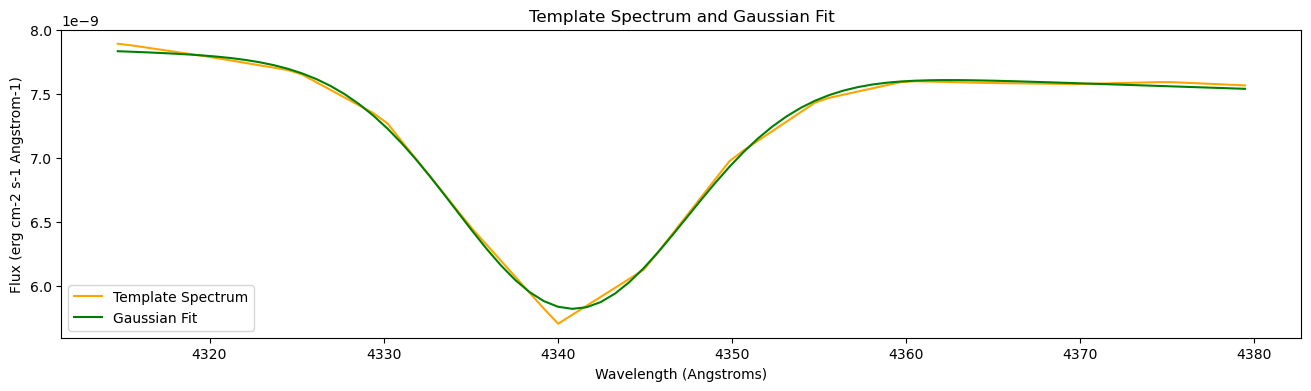

Fitted parameters: y0 = 0.00, m=-0.00, Amp = -0.00, Mean = 4340.79, Sigma = 6.64


In [20]:
# trim the spectrum to a single absorption line so the fit can work better
region_2 = SpectralRegion(4300*u.AA, 4380*u.AA)
pickles_spec_resampled_trimmed = extract_region(pickles_spec_resampled_truncated, region_2)

p0_2 = [1, 1, -4000, 4340, 5] # Input guess

popt_2, pcov_2 = curve_fit(gaussian, pickles_spec_resampled_trimmed.spectral_axis.value, pickles_spec_resampled_trimmed.flux.value, p0=p0_2)

plt.plot(pickles_spec_resampled_trimmed.spectral_axis.value, pickles_spec_resampled_trimmed.flux.value, label="Template Spectrum", color="orange")
plt.plot(pickles_spec_resampled_trimmed.spectral_axis.value, gaussian(pickles_spec_resampled_trimmed.spectral_axis.value, *popt_2), label="Gaussian Fit", color="green")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (erg cm-2 s-1 Angstrom-1)")
plt.title('Template Spectrum and Gaussian Fit')
plt.legend()
plt.show()

print("Fitted parameters: y0 = %.2f, m=%.2f, Amp = %.2f, Mean = %.2f, Sigma = %.2f" % tuple(popt_2))

Now that we have the Gaussians and their sigmas, we can set up the convolution.  The convolution of two Gaussians is another Gaussian, and since the absorption lines are approximately Gaussian-shaped, we can convolve one spectrum with a Gaussian to yield a lower-resolution spectrum.  The spectrum to be convolved is always the one with the higher resolution, i.e. narrower lines - here, that is the observed spectrum.

The variance of the Gaussian that is the convolution product of two Gaussians is $\sigma_{\rm conv}^2 = \sigma_{1}^2 + \sigma_{2}^2$.  Therefore, the width of the Gaussian convolution kernel needs to be $\sigma_{\rm kernel}^2 = \sigma_{\rm low-res}^2 - \sigma_{\rm high-res}^2$.

*However*, since the intrinsic (physical) line widths of the stars might differ (e.g. because they are in different luminosity classes), and because the shape of absorption lines is not perferctly Gaussian, you might have to manually change the width of the convolution kernel.

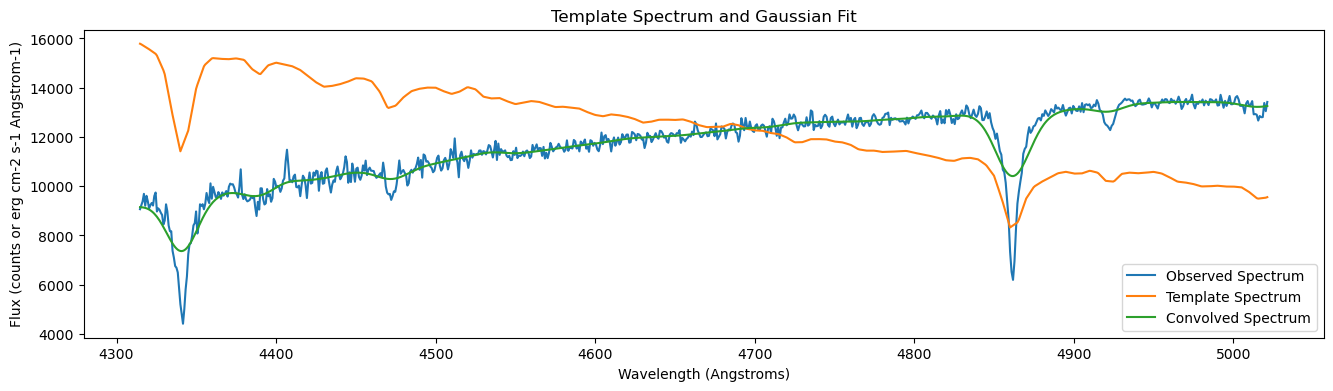

Kernel Stdev: 10.00 Angstroms


In [21]:
from astropy.convolution import Gaussian1DKernel, convolve

stddev = np.sqrt(popt_2[4]**2 - popt[4]**2) # Width of the convolution kernel
stddev = 10 # <---- Tune this so that absorption lines (mostly) disappear in the plot of the flux ratio
kernel = Gaussian1DKernel(stddev=stddev)
convolved_flux = convolve(observed_spec_resampled.flux, kernel, boundary='extend') 
convolved_spectrum = Spectrum1D(flux=convolved_flux, spectral_axis=observed_spec_resampled.spectral_axis)

plt.plot(observed_spec_resampled.spectral_axis, observed_spec_resampled.flux, label='Observed Spectrum')
plt.plot(pickles_spec_resampled_truncated.spectral_axis, pickles_spec_resampled_truncated.flux*2*10**12, label='Template Spectrum')
plt.plot(convolved_spectrum.spectral_axis, convolved_spectrum.flux, label='Convolved Spectrum')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (counts or erg cm-2 s-1 Angstrom-1)")
plt.title('Template Spectrum and Gaussian Fit')
plt.legend()
plt.show()
print(f"Kernel Stdev: {stddev:.2f} Angstroms")

And now the sensitivity function:

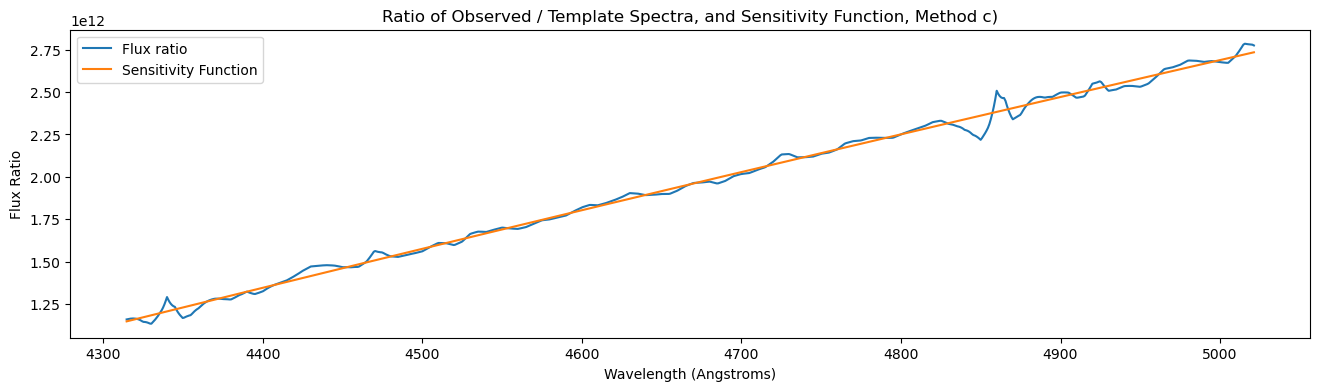

[-1.22265071e+05  3.38683020e+09 -1.11892913e+13]


In [22]:
# Ratio between the convolved observed spectrum and the template spectrum:
ratio_c = convolved_spectrum / pickles_spec_resampled_truncated

# Determine the sensitivity function:
coeffs_c = np.polyfit(ratio_c.spectral_axis.value, ratio_c.flux.value, 2)
sensitivity_function_c = np.polyval(coeffs_c, ratio_c.spectral_axis.value)

plt.plot(ratio_c.spectral_axis, ratio_c.flux, label='Flux ratio')
plt.plot(ratio_c.spectral_axis.value, sensitivity_function_c, label='Sensitivity Function')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux Ratio")
plt.title('Ratio of Observed / Template Spectra, and Sensitivity Function, Method c)')
plt.legend()
plt.show()

print(coeffs_c)